## Modelisation with UNET Mini

In [1]:
import sys  
sys.path.insert(0, './scripts')

# Import librairies, configs, helper functions
from helpers import *

config = base_config

# config["use_saved_model_path"] = "./model_delete.keras"
config["val_sample_nb"] = 100
config["train_sample_nb"] = 400
config["mlwflow_experiment_title"] = "UNET - Augmented"

n = NotebookProcessor(config)

{
    "width": 512,
    "height": 256,
    "classes": 8,
    "use_augment": true,
    "image_per_augment": 1,
    "max_evals": 1,
    "mlwflow_tracking_uri": "http://127.0.0.1:5000",
    "mlwflow_experiment_title": "UNET - Augmented",
    "train_sample_nb": 400,
    "val_sample_nb": 100,
    "use_saved_model_path": "",
    "gtFine_path": "./data/P8_Cityscapes_gtFine_trainvaltest.zip",
    "leftImg8bit_path": "./data/P8_Cityscapes_leftImg8bit_trainvaltest.zip",
    "data_path": "./data/gtFine"
} 

Dataset already exist, skip downloading: ./data/P8_Cityscapes_gtFine_trainvaltest.zip
Dataset already exist, skip downloading: ./data/P8_Cityscapes_leftImg8bit_trainvaltest.zip

- Sampling the training dataset from 2975 to 400.

- Sampling the validation dataset from 326 to 100.


## Model definition

The model tested here is UNet.

>It features a contracting path on the left (encoder), which captures context by downsampling, and an expansive path on the right (decoder), which helps in precise localization by upsampling. In the middle, there is a bottleneck layer before the model transitions from downsampling to upsampling. Skip connections are used between corresponding layers in the contracting and expansive paths to help preserve spatial information lost during downsampling.

Here we start at 16 filters all the way to 128 and back to 16

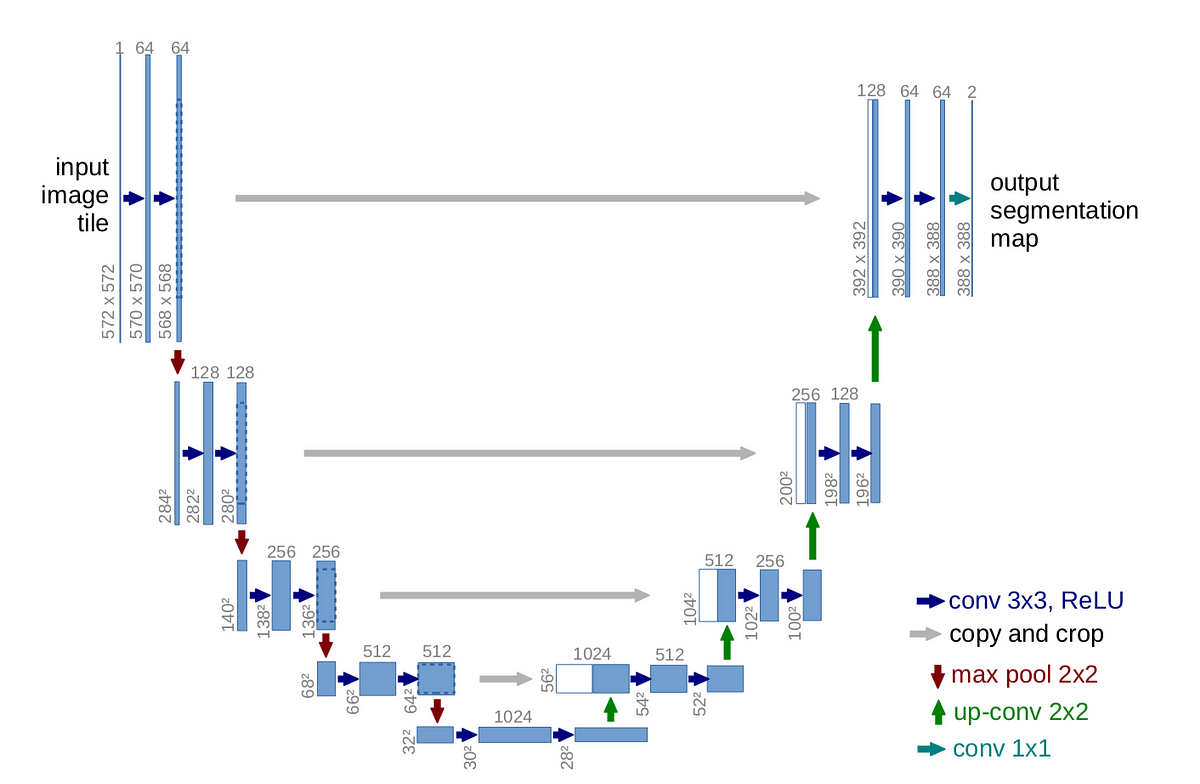

## Model creation

In [2]:
def conv_block(input_tensor, num_filters, dropout_rate=0.1):  
    x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input_tensor)  
    x = BatchNormalization()(x)  # Adding batch normalization  
    x = Dropout(dropout_rate)(x)  
    x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)  
    x = BatchNormalization()(x)  # Adding batch normalization  
    return x  
  
def create_model(n_classes, img_width, img_height, img_channels):  
    inputs = Input((img_height, img_width, img_channels))  
  
    # Contraction path  
    c1 = conv_block(inputs, 16)  
    p1 = MaxPooling2D((2, 2))(c1)  
      
    c2 = conv_block(p1, 32)  
    p2 = MaxPooling2D((2, 2))(c2)  
      
    c3 = conv_block(p2, 64)  
    p3 = MaxPooling2D((2, 2))(c3)  
      
    c4 = conv_block(p3, 128)  
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)  
      
    c5 = conv_block(p4, 256, 0.3)  # Increased dropout for the deepest block  
      
    # Expansive path   
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)  
    u6 = concatenate([u6, c4])  
    c6 = conv_block(u6, 128)  
       
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)  
    u7 = concatenate([u7, c3])  
    c7 = conv_block(u7, 64, 0.2)  # Modify dropout rate for specific layers if needed  
      
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)  
    u8 = concatenate([u8, c2])  
    c8 = conv_block(u8, 32)  
       
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)  
    u9 = concatenate([u9, c1])  
    c9 = conv_block(u9, 16)  
       
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)  
       
    model = Model(inputs=[inputs], outputs=[outputs])  
    return model

## Model Stats

### With augment

2024-03-01 11:22:10.951896: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-03-01 11:22:10.951921: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-03-01 11:22:10.951923: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-03-01 11:22:10.951970: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-01 11:22:10.952001: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


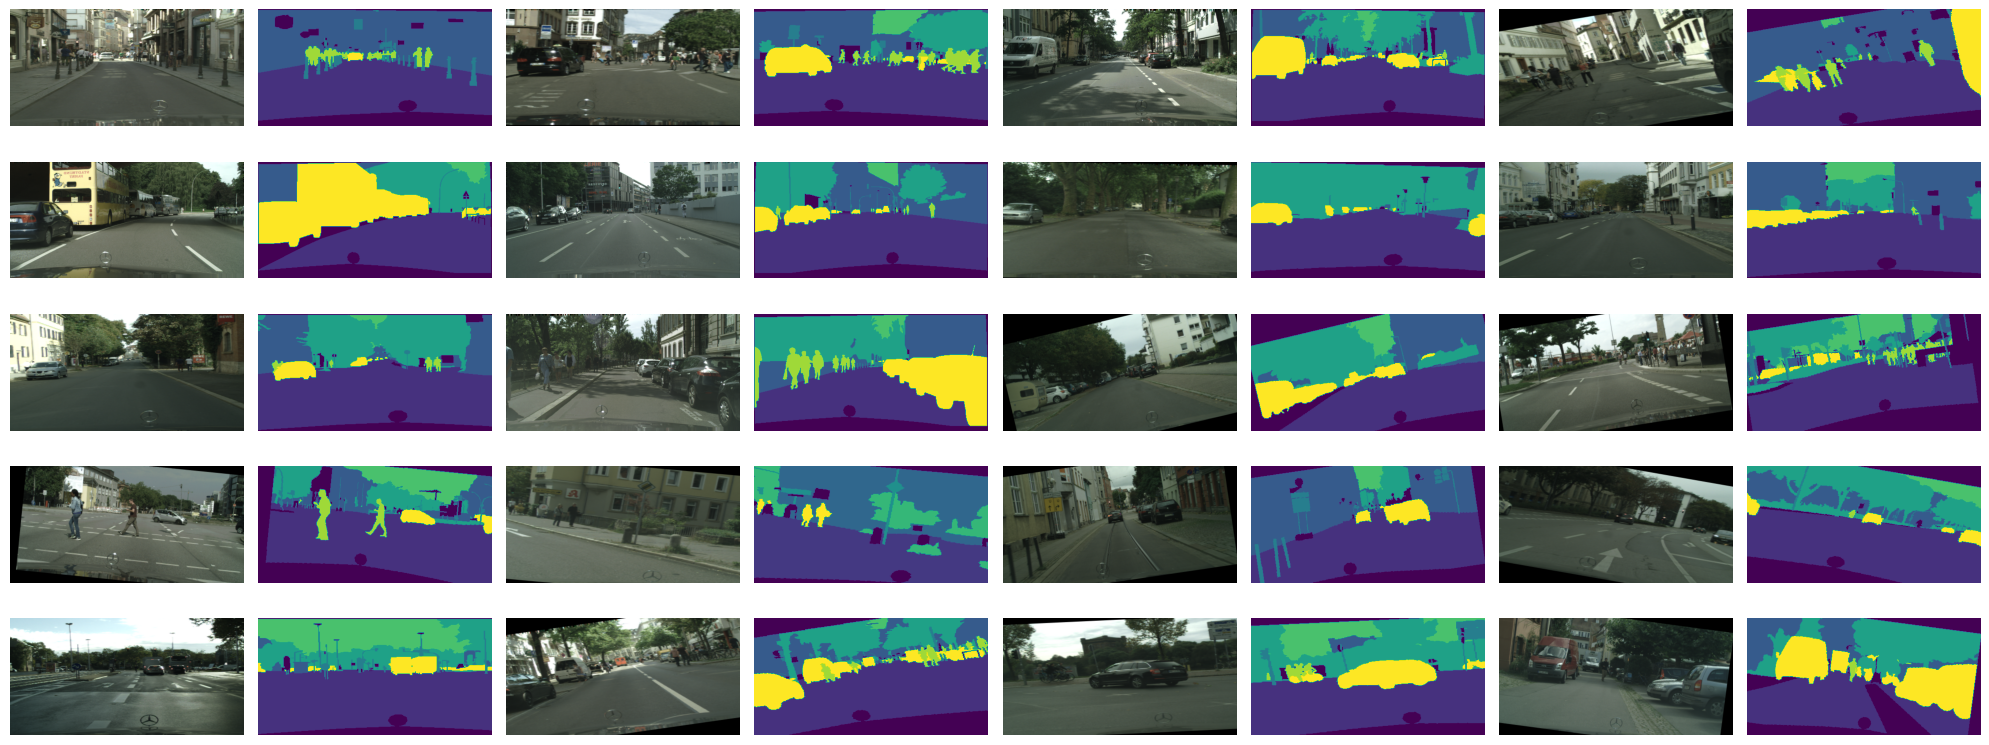

In [3]:
show_data_generator_images_sample(n)

In [4]:
model = create_model(n_classes=config["classes"], img_width=config["width"], img_height=config["height"], img_channels=3)
n.set_model(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 512, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 512, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 dropout (Dropout)           (None, 256, 512, 16)         0         ['batch_normalization[0][0

In [5]:
n.model_fit()

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

2024/02/29 10:14:43 INFO mlflow.tracking.fluent: Experiment with name 'UNET - Augmented' does not exist. Creating a new experiment.



Epoch 1/12                                           

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

2024-02-29 10:14:45.516562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


991/991 [==============================] - 320s 320ms/step - loss: 0.6953 - dice_coef: 0.6740 - iou: 0.5201 - accuracy: 0.7831 - val_loss: 0.8659 - val_dice_coef: 0.6838 - val_iou: 0.5270 - val_accuracy: 0.7365

Epoch 2/12                                           

991/991 [==============================] - 353s 356ms/step - loss: 0.4976 - dice_coef: 0.7660 - iou: 0.6257 - accuracy: 0.8441 - val_loss: 0.5427 - val_dice_coef: 0.7622 - val_iou: 0.6235 - val_accuracy: 0.8280

Epoch 3/12                                           

991/991 [==============================] - 317s 319ms/step - loss: 0.4362 - dice_coef: 0.7953 - iou: 0.6652 - accuracy: 0.8635 - val_loss: 0.5756 - val_dice_coef: 0.7475 - val_iou: 0.6055 - val_accuracy: 0.8233

Epoch 4/12                                           

991/991 [==============================] - 386s 390ms/step - loss: 0.4091 - dice_coef: 0.8083 - iou: 0.6833 - accuracy: 0.8730 - val_loss: 0.5264 - val_dice_coef: 0.7786 - val_iou: 0.6448 - val_accur

In [5]:
display_loss_and_accuracy(n.model_fit_history)
n.model_predict_with_display_and_accuracy(n.img["val"][0],n.mask["val"][0])

AttributeError: 'NotebookProcessor' object has no attribute 'model_fit_history'

### Without augment

{
    "width": 512,
    "height": 256,
    "classes": 8,
    "use_augment": false,
    "image_per_augment": 1,
    "max_evals": 1,
    "mlwflow_tracking_uri": "http://127.0.0.1:5000",
    "mlwflow_experiment_title": "UNET - Not Augmented",
    "train_sample_nb": 0,
    "val_sample_nb": 0,
    "use_saved_model_path": "",
    "gtFine_path": "./data/P8_Cityscapes_gtFine_trainvaltest.zip",
    "leftImg8bit_path": "./data/P8_Cityscapes_leftImg8bit_trainvaltest.zip",
    "data_path": "./data/gtFine"
} 

Dataset already exist, skip downloading: ./data/P8_Cityscapes_gtFine_trainvaltest.zip
Dataset already exist, skip downloading: ./data/P8_Cityscapes_leftImg8bit_trainvaltest.zip
- Using the full training dataset
- Using the full validation dataset


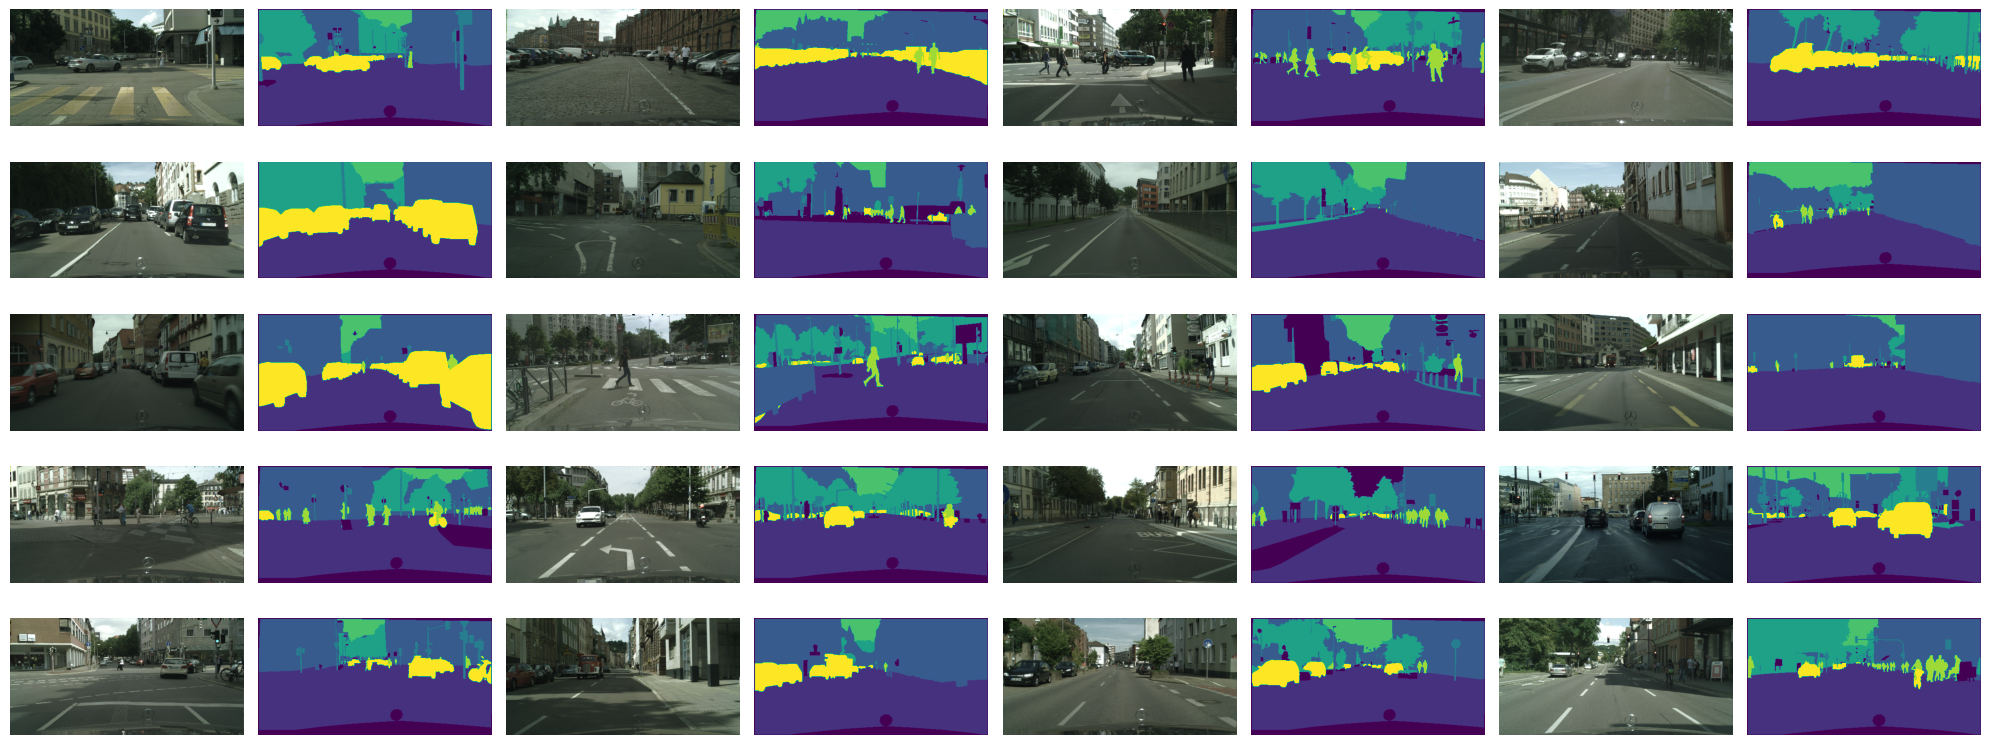

In [7]:
config_not_aug = {
    **config,
    "use_augment": False,
    "mlwflow_experiment_title":"UNET - Not Augmented"
}

n_not_aug = NotebookProcessor(config_not_aug)
show_data_generator_images_sample(n_not_aug)

In [8]:
model_not_aug = create_model(n_classes=config["classes"], img_width=config["width"], img_height=config["height"], img_channels=3)
n_not_aug.set_model(model_not_aug)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 512, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 512, 16)         448       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 256, 512, 16)         64        ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 dropout_9 (Dropout)         (None, 256, 512, 16)         0         ['batch_normalization_18

In [9]:
n_not_aug.model_fit()

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

2024/02/29 11:28:59 INFO mlflow.tracking.fluent: Experiment with name 'UNET - Not Augmented' does not exist. Creating a new experiment.



Epoch 1/12                                           

991/991 [==============================] - 444s 446ms/step - loss: 0.6762 - dice_coef: 0.6843 - iou: 0.5307 - accuracy: 0.7919 - val_loss: 0.6939 - val_dice_coef: 0.7279 - val_iou: 0.5796 - val_accuracy: 0.7868

Epoch 2/12                                           

991/991 [==============================] - 406s 410ms/step - loss: 0.4932 - dice_coef: 0.7690 - iou: 0.6296 - accuracy: 0.8457 - val_loss: 0.6246 - val_dice_coef: 0.7306 - val_iou: 0.5847 - val_accuracy: 0.8030

Epoch 3/12                                           

991/991 [==============================] - 428s 432ms/step - loss: 0.4411 - dice_coef: 0.7935 - iou: 0.6629 - accuracy: 0.8625 - val_loss: 0.5365 - val_dice_coef: 0.7713 - val_iou: 0.6352 - val_accuracy: 0.8338

Epoch 4/12                                           

991/991 [==============================] - 420s 423ms/step - loss: 0.4041 - dice_coef: 0.8099 - iou: 0.6853 - accuracy: 0.8742 - val_loss: 0.508

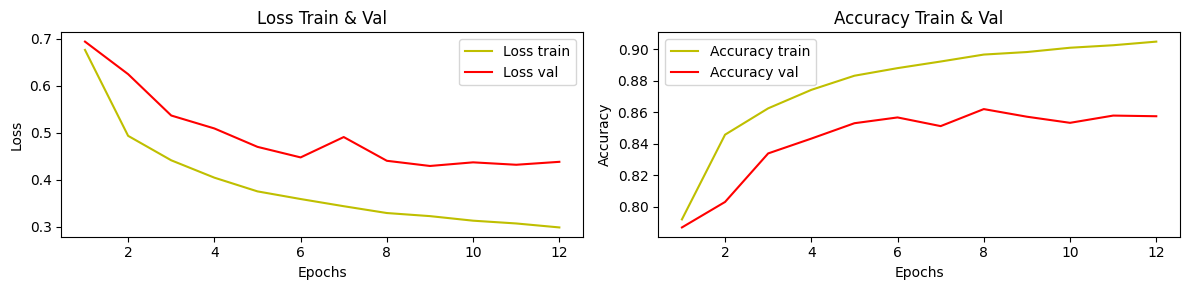

1/1 [==============================] - 1s 544ms/step


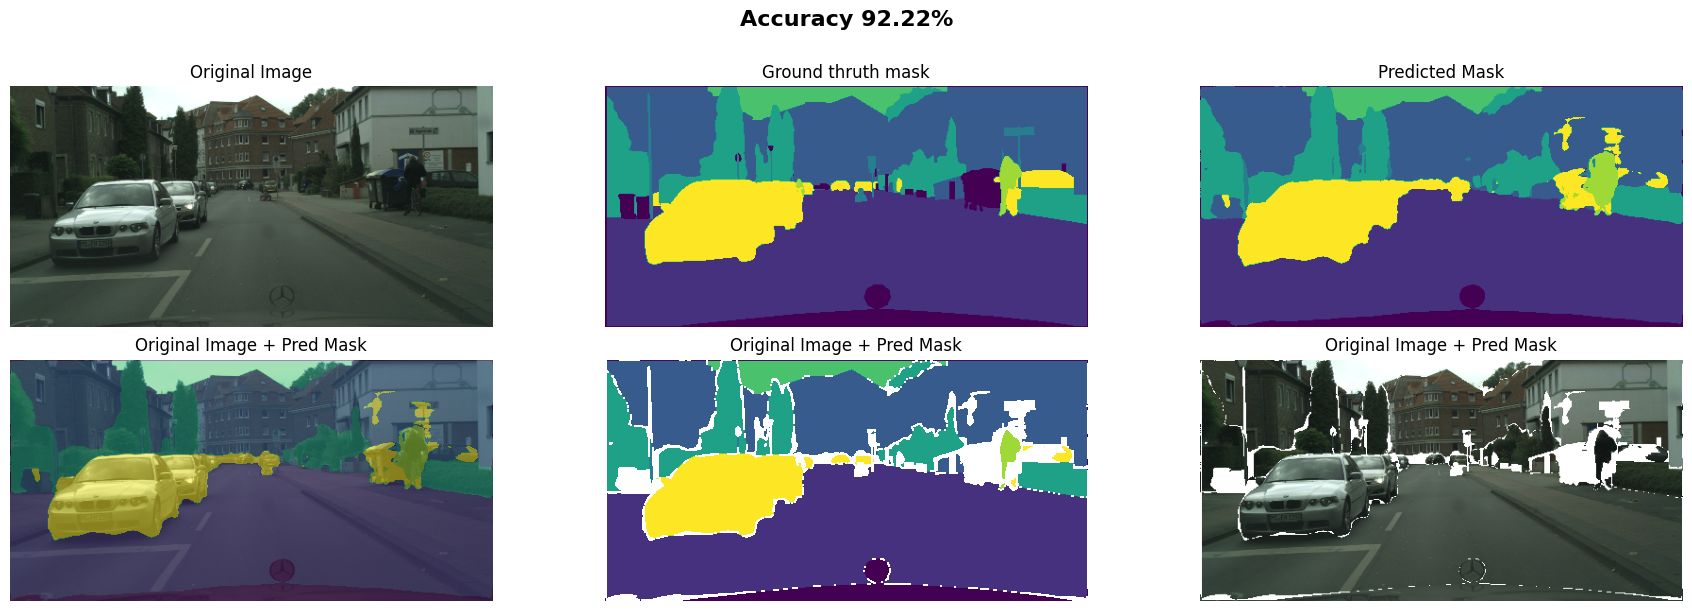

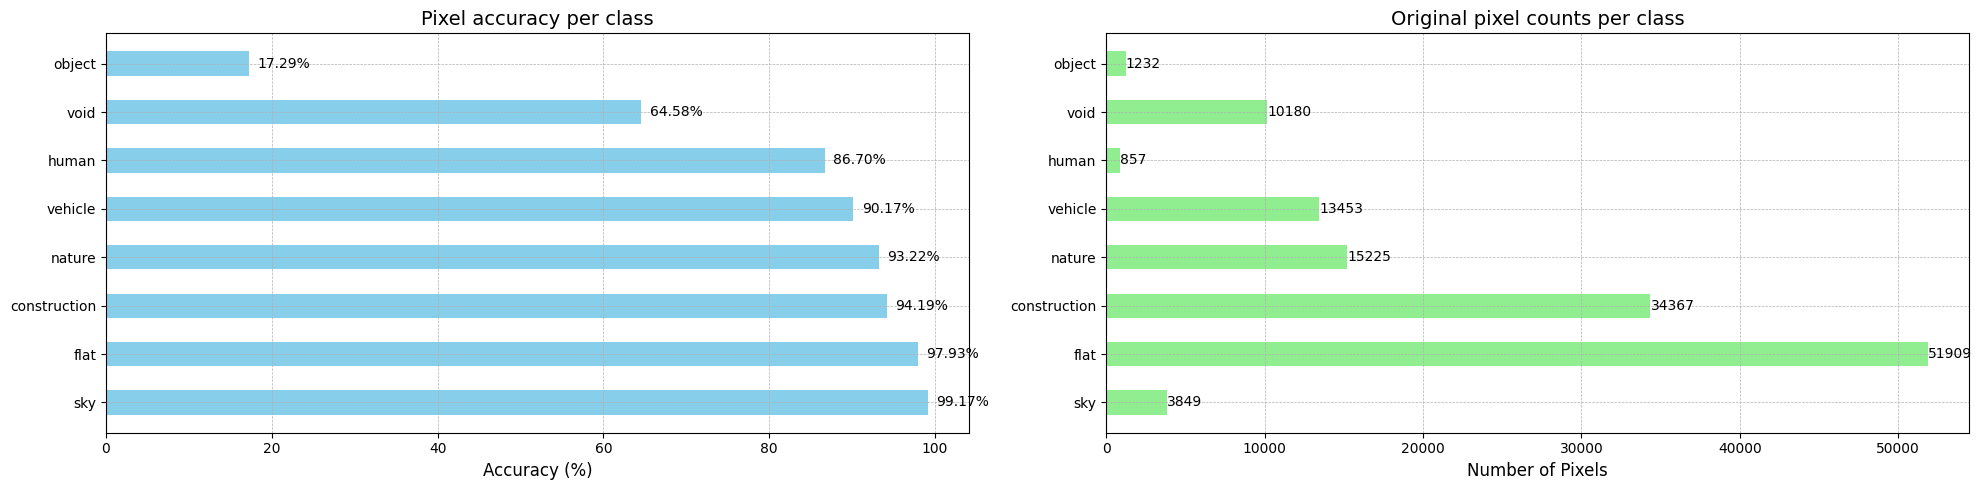

In [10]:
display_loss_and_accuracy(n_not_aug.model_fit_history)
n_not_aug.model_predict_with_display_and_accuracy(n_not_aug.img["test"][1],n_not_aug.mask["test"][1])

### Performance comparaison augmented vs not

58/58 [==============================] - 16s 268ms/step - loss: 0.2599 - dice_coef: 0.8713 - iou: 0.7753 - accuracy: 0.9146


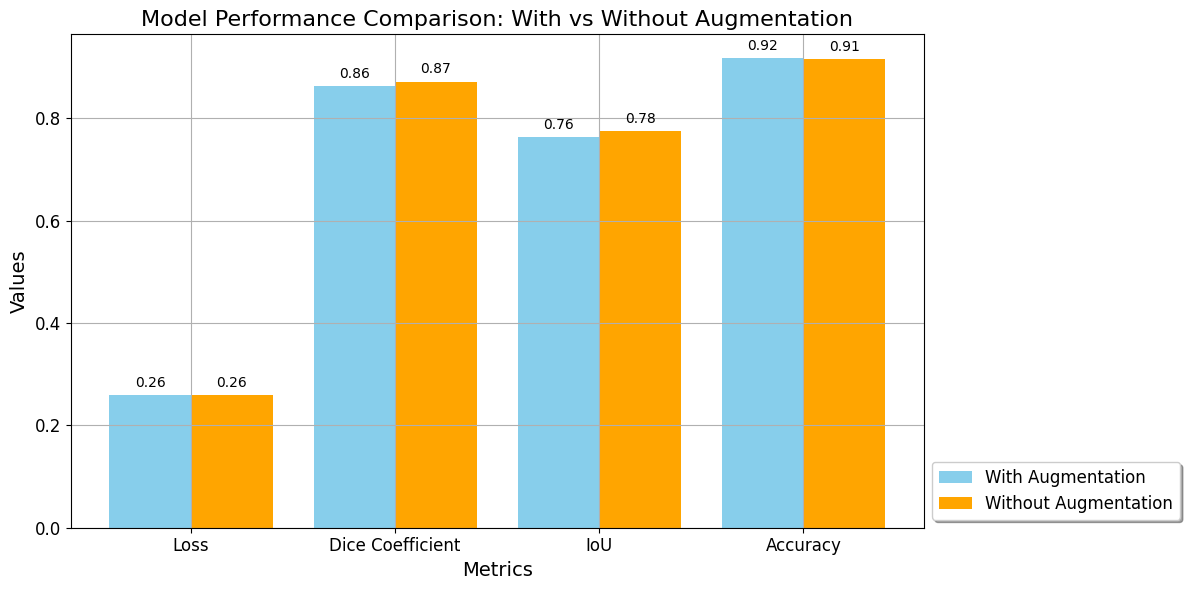

In [11]:
evaluate_with_and_without_aug(n, n_not_aug)

## Model Inference

In [12]:
n.model.save("model.keras")
model = tf.keras.models.load_model("model.keras", custom_objects={'dice_coef': dice_coef, 'iou': iou})

1/1 [==============================] - 0s 25ms/step


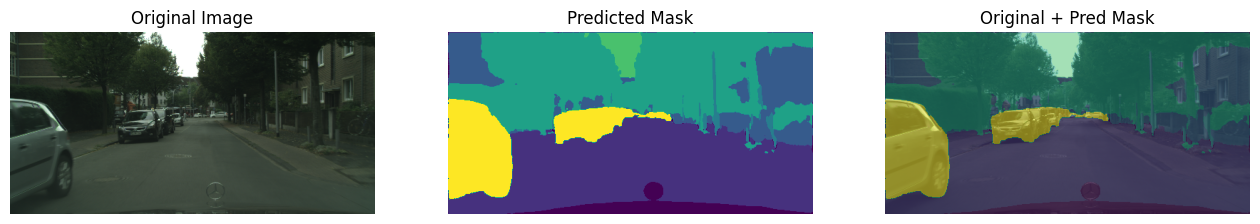

In [13]:
n.model_inference_with_display(n.img["test"][3])

1/1 [==============================] - 0s 20ms/step


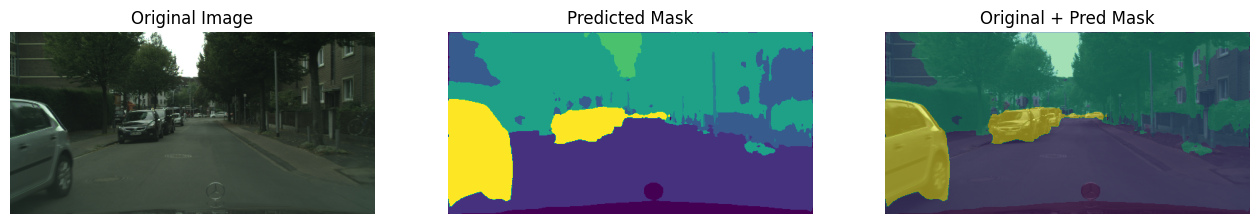

In [14]:
n_not_aug.model_inference_with_display(n_not_aug.img["test"][3])